# Figs of WMT tendency terms
## Table Of Contents: <a class="anchor" id="top"> </a>
* [Annual-mean global fig of each term](#first-bullet)
* [Global timeseries of each term](#second-bullet)
* [Monthly Climatology](#third-bullet)

> Note: the time dimension is only for first 6 months of CESM data

In [6]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.c4549e4b7057434c949186b64ccff465/status,


In [36]:
cluster.close()
client.close()

In [1]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
import fastjmd95
import pop_tools
import gcsfs
from xhistogram.xarray import histogram
import pop_tools
import xesmf as xe

In [2]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

histograms = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/histograms.zarr'))
histograms

<xarray.Dataset>
Dimensions:          (time: 14965, rho0_bin: 1499)
Coordinates:
  * rho0_bin         (rho0_bin) float64 1.015e+03 1.015e+03 ... 1.03e+03
  * time             (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:00:00
Data variables:
    OMEGA_cabbeling  (time, rho0_bin) float64 dask.array<chunksize=(1, 1499), meta=np.ndarray>
    OMEGA_rho        (time, rho0_bin) float64 dask.array<chunksize=(1, 1499), meta=np.ndarray>
    OMEGA_sss        (time, rho0_bin) float64 dask.array<chunksize=(1, 1499), meta=np.ndarray>
    OMEGA_sst        (time, rho0_bin) float64 dask.array<chunksize=(1, 1499), meta=np.ndarray>

# 1) Annual-mean global fig <a class='anchor' id='first-bullet'> </a>
(use logarithmic scale on y-axis)

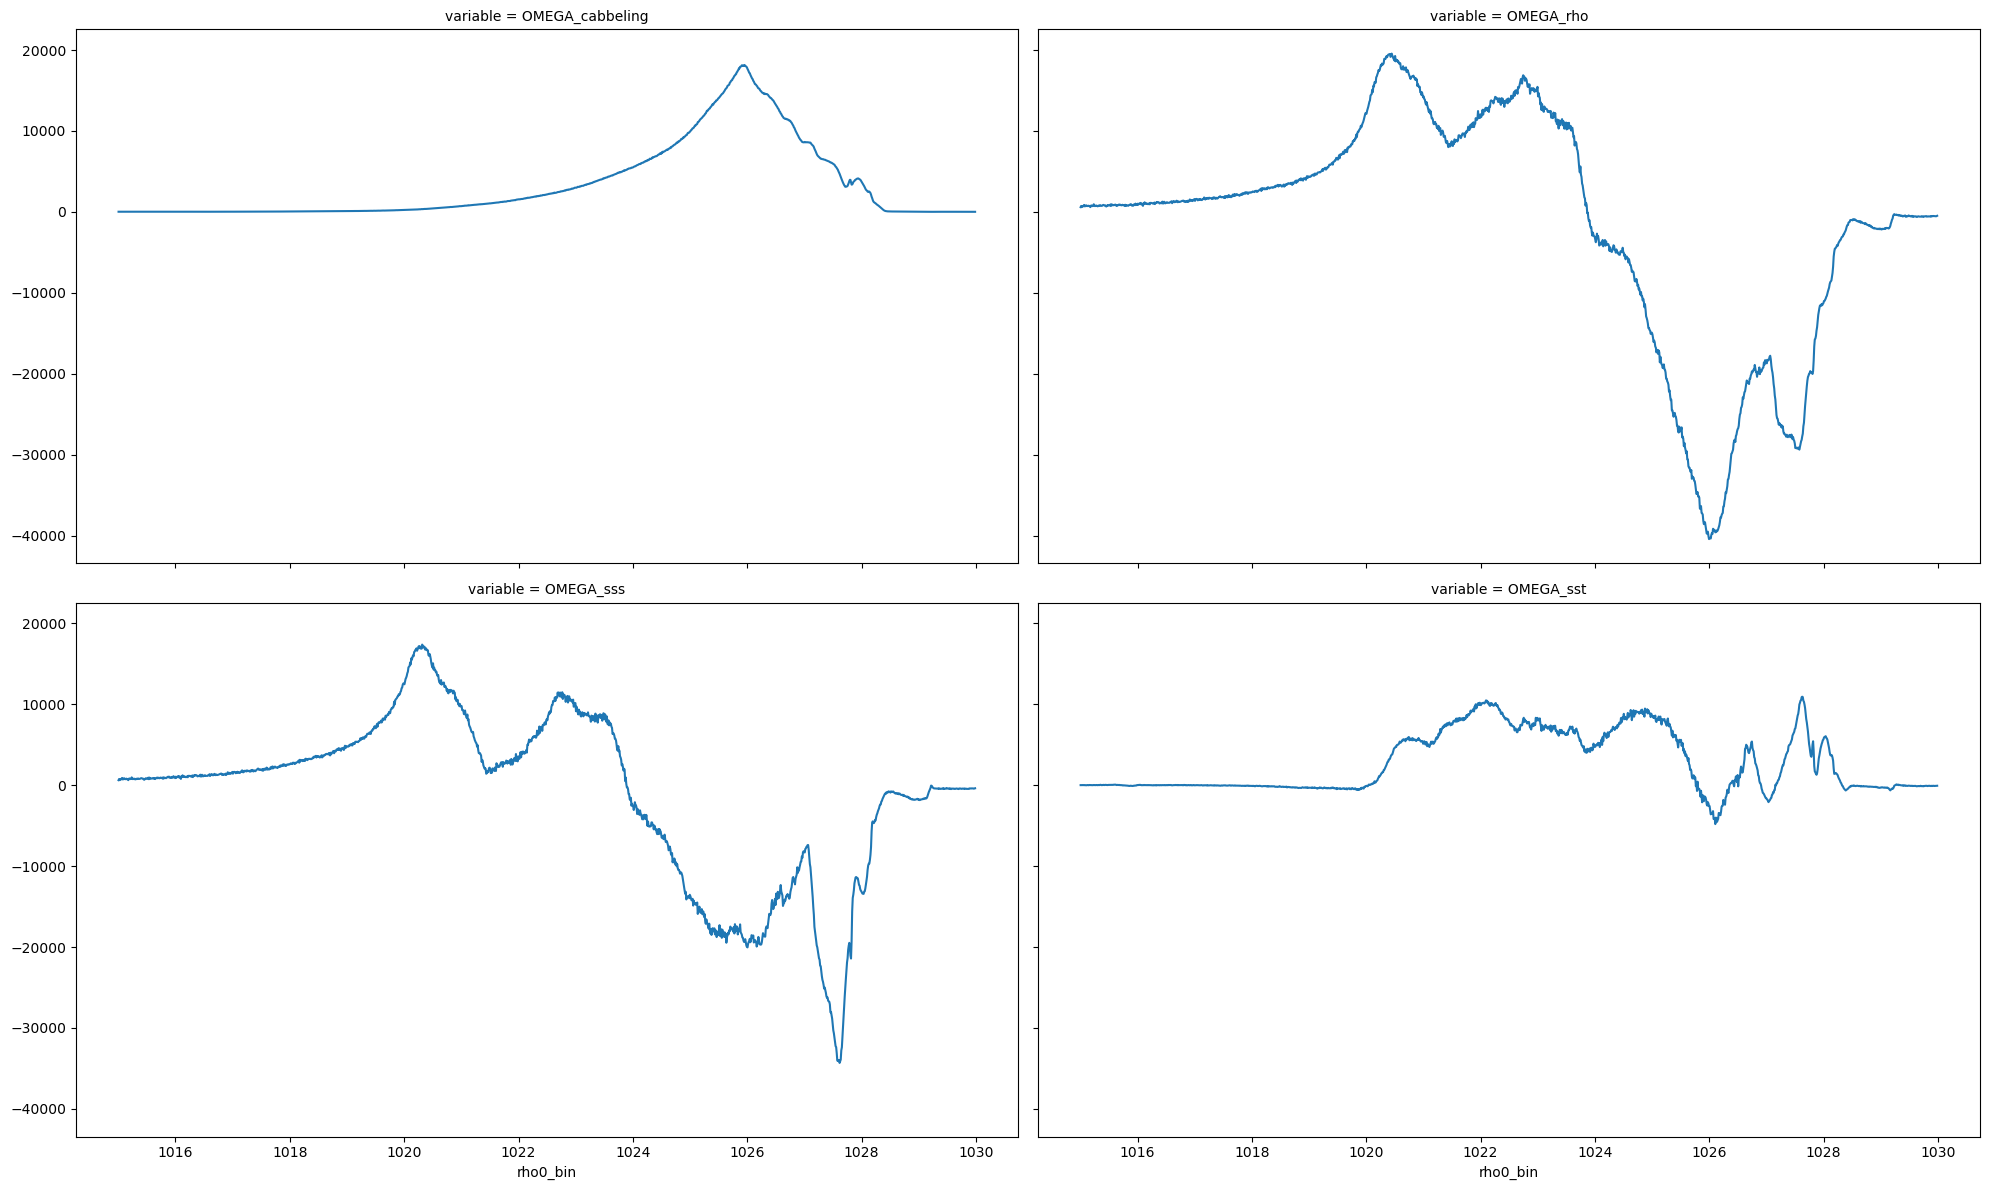

In [7]:
#instead of Sv (/1e6), it's m^2
(histograms/1e4).mean('time').to_array().plot(col='variable', col_wrap=2, figsize=(20, 12));

Task exception was never retrieved
future: <Task finished name='Task-2824' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:2119> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py", line 2128, in wait
    raise AllExit()
distributed.client.AllExit


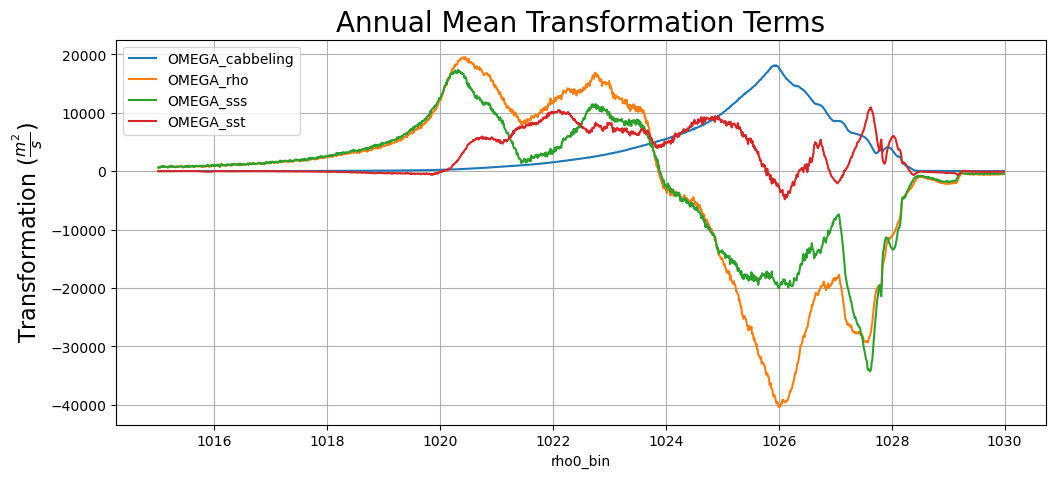

In [30]:
fig = plt.figure(figsize=(12,5))
for i in list(histograms.data_vars):
    (histograms[i].mean('time')/1e4).plot(label=f'{i}')
plt.legend()
plt.ylabel(r'Transformation ($\frac{m^2}{s}$)', fontsize=16)
plt.grid()
plt.title('Annual Mean Transformation Terms', fontsize=20);

# 2) Global timeseries fig <a class='anchor' id='second-bullet'> </a>

In [ ]:
#instead of Sv (/1e6) it's m^2/s
(histograms/1e4).to_array().T.plot(col='variable', col_wrap=2, figsize=(20, 12), 
                             cmap='magma')
plt.ylim(1027, 1018);

# 3) Global Monthly Climatology <a class='anchor' id='third-bullet'> </a>

In [78]:
def anomaly(da):
    def clim(da):
        clim = da.groupby('time.month').mean(dim='time')
        return clim
    
    clim = clim(da) / 1e4
    anom = (da.groupby('time.month') - clim) / 1e4
    #anom_chunk = anom.chunk({'time':-1, 'sigma2_bin':-1})
    #anom_rolled = anom.rolling(time=36, center=True).mean(dim='time') #annual rolling mean to remove seasonal cycle
    return (clim, anom)

In [118]:
clim = anomaly(histograms)[0]
anom = anomaly(histograms)[1]

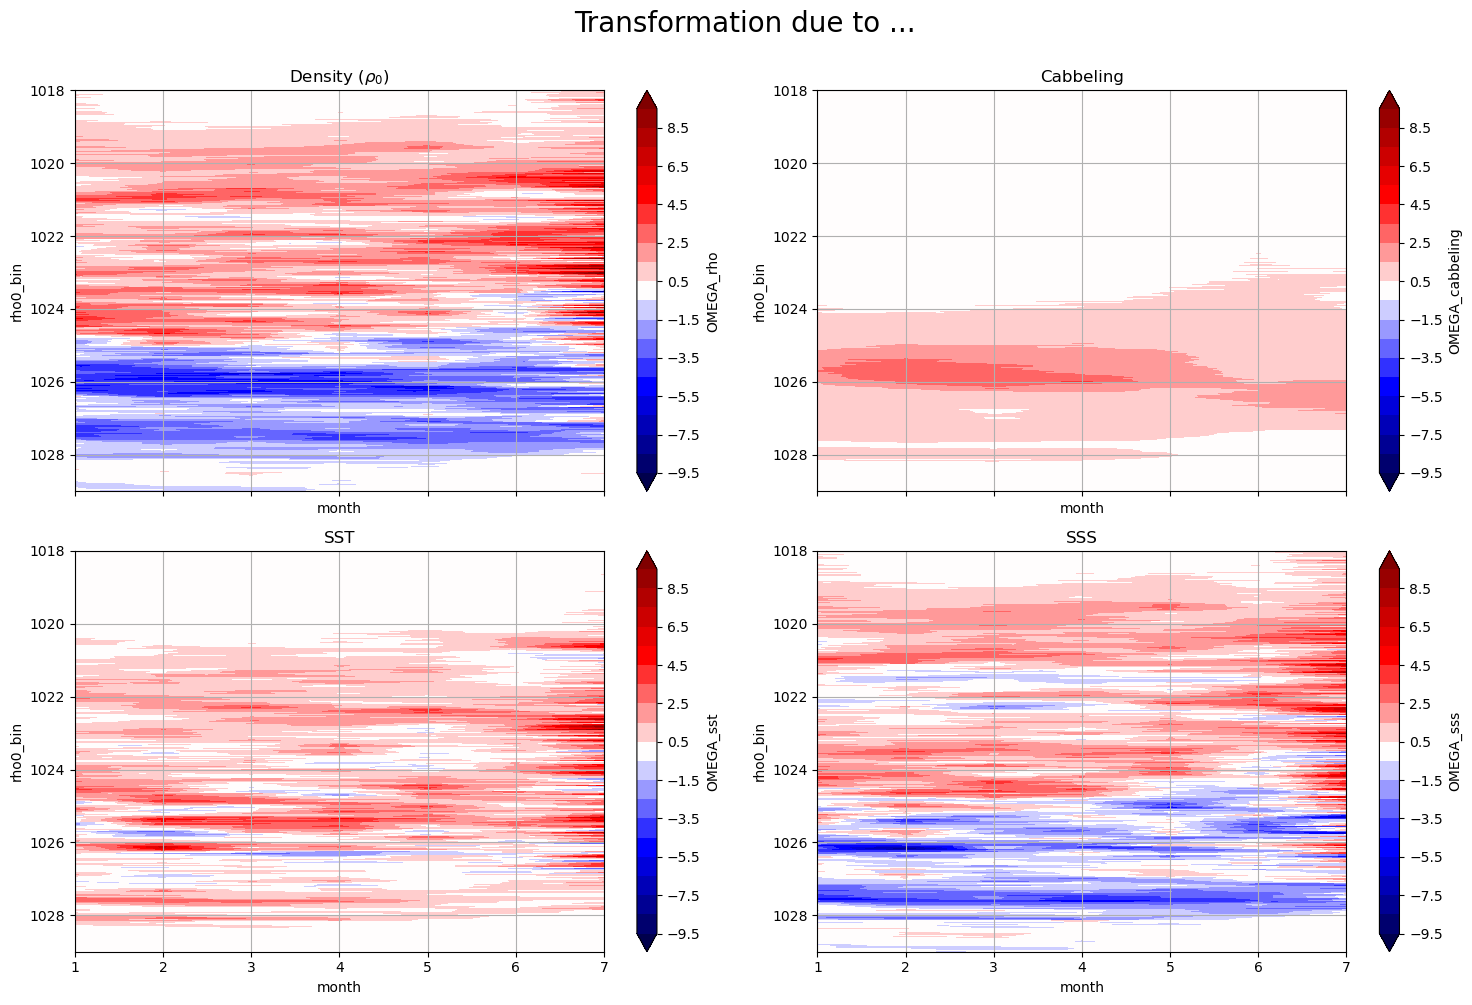

In [138]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True)

levels = np.arange(-10, 10) + 0.5

clim.OMEGA_rho.plot.contourf(x='month', cmap='seismic', levels=levels, extend='both', ax=axes[0,0])
axes[0,0].set_title(r'Density ($\rho_0$)')
axes[0,0].set_ylim(1029, 1018)
axes[0,0].grid()

clim.OMEGA_cabbeling.plot.contourf(x='month', cmap='seismic', levels=levels, extend='both', ax=axes[0,1])
axes[0,1].set_title('Cabbeling')
axes[0,1].set_ylim(1029, 1018)
axes[0,1].grid()

clim.OMEGA_sst.plot.contourf(x='month', cmap='seismic', levels=levels, extend='both', ax=axes[1,0])
axes[1,0].set_title('SST')
axes[1,0].set_ylim(1029, 1018)
axes[1,0].grid()

clim.OMEGA_sss.plot.contourf(x='month', cmap='seismic', levels=levels, extend='both', ax=axes[1,1])
axes[1,1].set_title('SSS')
axes[1,1].set_ylim(1029, 1018)
axes[1,1].grid()

plt.suptitle('Transformation due to ...', fontsize=20, y=1)
plt.tight_layout();

# 3) Global Anomaly <a class='anchor' id='third-bullet'> </a>

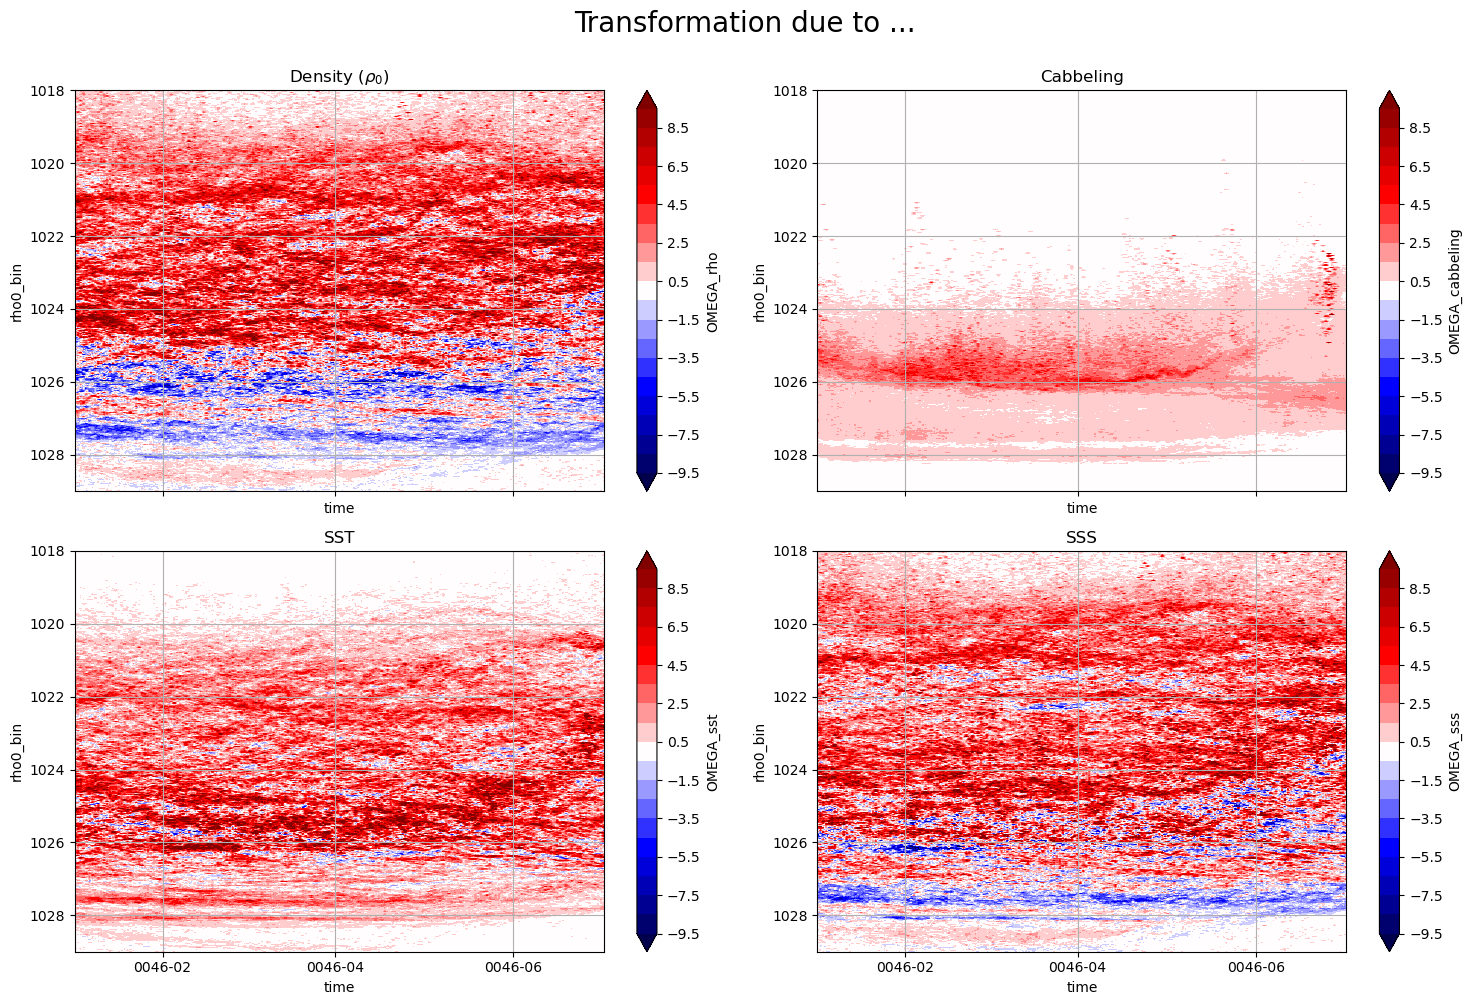

In [140]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True)

levels = np.arange(-10, 10) + 0.5

anom.OMEGA_rho.plot.contourf(x='time', cmap='seismic', levels=levels, extend='both', ax=axes[0,0])
axes[0,0].set_title(r'Density ($\rho_0$)')
axes[0,0].set_ylim(1029, 1018)
axes[0,0].grid()

anom.OMEGA_cabbeling.plot.contourf(x='time', cmap='seismic', levels=levels, extend='both', ax=axes[0,1])
axes[0,1].set_title('Cabbeling')
axes[0,1].set_ylim(1029, 1018)
axes[0,1].grid()

anom.OMEGA_sst.plot.contourf(x='time', cmap='seismic', levels=levels, extend='both', ax=axes[1,0])
axes[1,0].set_title('SST')
axes[1,0].set_ylim(1029, 1018)
axes[1,0].grid()

anom.OMEGA_sss.plot.contourf(x='time', cmap='seismic', levels=levels, extend='both', ax=axes[1,1])
axes[1,1].set_title('SSS')
axes[1,1].set_ylim(1029, 1018)
axes[1,1].grid()

plt.suptitle('Transformation due to ...', fontsize=20, y=1)
plt.tight_layout();

# 4) Basin-wide timeseries fig

In [11]:
grid_name = 'POP_gx1v7'

grid = pop_tools.get_grid(grid_name)
mask3d = pop_tools.region_mask_3d(grid_name, mask_name='default')

In [12]:
mask3d.region

<xarray.DataArray 'region' (region: 13)>
array(['Black Sea', 'Baltic Sea', 'Red Sea', 'Southern Ocean', 'Pacific Ocean',
       'Indian Ocean', 'Persian Gulf', 'Atlantic Ocean', 'Mediterranean Sea',
       'Lab. Sea & Baffin Bay', 'GIN Seas', 'Arctic Ocean', 'Hudson Bay'],
      dtype='<U21')
Coordinates:
  * region   (region) <U21 'Black Sea' 'Baltic Sea' ... 'Hudson Bay'

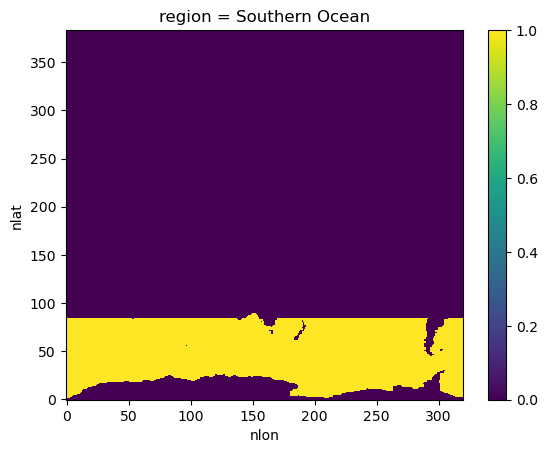

In [13]:
mask3d.sel(region='Southern Ocean').plot()